This notebook demonstrates the possibilities of **latent semantic analysis** to extract similarities from large amounts of text.

## LSA

A major problem with text analysis is to extract the actual meaning of textual contents. Single text elements only contain very limited information for understanding semantic. There might be elements (synonyms) which contain the same semantic meaning. Also, the context in which words appear are affecting their meaning (polysemy). LSA attempts to identify the latent, not directly observable meaning of text. For this, text elements will be projected into a vector space. In this exmaple, LSA will be used to find movie reviews with high similarity. The Analysis is based upon over [66.000 reviews](http://www.dropbox.com/s/k2vyti6pxzmmr73/imdb-reviews.txt) from the international movie database *IMDB*.

## Preparations

First the reviews will be read and stored in a python list.

In [1]:
import csv
import nltk
import pickle
from nltk.corpus import stopwords
from gensim import corpora, models, similarities
import codecs
import seaborn as sns
sns.set(style="darkgrid")
%pylab inline

def saveobject(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def loadobject(filename):
    with open(filename, 'rb') as f:
        output = pickle.load(f)
        return output

Populating the interactive namespace from numpy and matplotlib


In [4]:
reviews = []
inputfile = codecs.open("imdb-reviews.txt", encoding='utf-8')
once = []
for line in inputfile:
    reviews.append([line])   
inputfile.close()
reviews = [review for review in reviews if review !=[]]
reviews = [review for review in reviews if review !=["\n"]]

The list contains a total of 66.066 reviews (which are themselves presented as strings within lists). The following output shows one of the reviews.

In [5]:
print len(reviews)
print reviews[1337]

66066
[u"1336 1336 Three young doctors with markedly different backgrounds and motives work in the small Texas town of Cutter, 60 miles from Houston. When they run into medical problems their local facility can't handle, they contact the Texas Medical Center in Houston. \n"]


Now, all reviews will be tokenized and semantical meaningless stopwords like *the* or *and* will be removed to reduce unnecessary noise.

In [6]:
engstopwords = stopwords.words('english')

tokens = [[word.lower() for word in nltk.word_tokenize(review[0])\
 if word.lower() not in engstopwords and word.isalpha()] for review in reviews]

saveobject(tokens, "review_tokens")

In [9]:
bow = [tok for doc in tokens for tok in doc]

In [11]:
frequ = nltk.FreqDist(bow)

The frequency distribution of the 20 most common words is shown below. Here, stopwords are already removed.


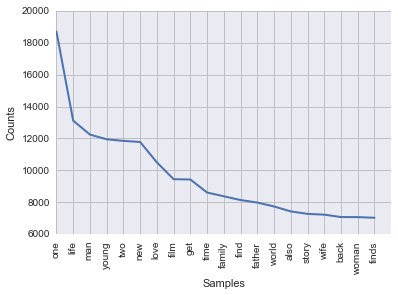

In [13]:
frequ.plot(20)

Just to show some basic text analysis features, we can look up for the concordance of a given word. The term *love* appears 10499 times and the movie reviews and the first 10 occurences are listed below.

In [26]:
nltk.Text(bow).concordance("love", lines=10)

Displaying 10 of 10499 matches:
big boobies painting everybody would love get hands also two downed idiot brit
ends young man problems finding true love brother tries help avail seemed thou
enowned cascadia tennis academy live love laugh fight cry dream way adolescenc
ry school meet weekly local bar talk love sex career future relationships amon
loria decides accompany gloria makes love made illusions miguel ruined discove
 apache chief cochise jeffords falls love beautiful woman cochise tribe sonsee
very single episode wyatt hopelessly love older caitlin endures daily humiliat
rs adults families friends neighbors love interests various members family wei
roughout stories death crime stories love friendship peter esther seemingly ha
 nightclubs schiffer offers informer love play part martin life fatal conseque


We can also look up frequently aligned tokens, socalled *bigrams*. The output also indicates a serious problem for text analysis: the bigram  *new york* for example cleary represents a town, although *new* and *york* are separate tokens in our corpus. For maximum performance, all such cases should be examined and adapted manually if needed.

In [16]:
nltk.Text(bow).collocations()

new york; falls love; los angeles; high school; united states; one
day; years later; young man; best friend; fall love; world war; san
francisco; young woman; hong kong; years ago; year old; small town;
martial arts; york city; along way


## Review transformation

For the next step we create a gensim dictionary and transform reviews to numeric vectors afterwars. Each token will be assigned to an id which serves as a key to the word frequency as value.

In [20]:
%cd "E:\Dropbox\Soziologie Master\Quantitative Textanalysen mit Python\Berichte\3. Bericht"
tokens = loadobject("review_tokens")
dictionary = corpora.Dictionary(tokens)
dictionary.save('moviereviews.dict')

corpus = [dictionary.doc2bow(token) for token in tokens]
print corpus[1337]

E:\Dropbox\Soziologie Master\Quantitative Textanalysen mit Python\Berichte\3. Bericht
[(114, 1), (412, 1), (546, 1), (571, 1), (585, 1), (587, 1), (728, 1), (737, 1), (1071, 1), (1247, 1), (1291, 2), (1751, 1), (1753, 1), (1815, 1), (2509, 1), (3102, 1), (4236, 1), (4360, 2), (4425, 1), (5673, 1), (6976, 2), (13384, 1), (14780, 1)]


## TFIDF-Weights

As token appearance varies greatly in the movie reviews, the will be weighted according to their frequencies. A term which only appears in five percent of the reviews should therefore receive more weight than a term appearing in over 90%. The weighting used in this case is called TFIDF, which is based upon the following formula:


\begin{equation}
TFIDF_{i,j}= N_{i,j} * log\left (D / D_{i}  \right )
\end{equation}


- <i>Ni,j</i> word frequency <i>i</i> in document <i>j</i>, 
- <i>D</i> number of documents 
- <i>Di</i> number of documents which contain word <i>i</i>.

The logarithm is used to calculate the inverse document frequency.

In [21]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

## Singular Value Decomposition

After these preparations we can finally apply the most important part of LSA: the dimension reduction using singular value decompoisition. Here, the constructed $n \times m$ document/word-Matrix  <i>A</i> will be splitted into three matrices


\begin{equation}
A = U \Sigma V^* \;
\end{equation}


- $U$    = orthogonal $n \times n$ matrix
- $V^*$ = transposition of an orthogonal  $m \times m$ matrix $V$
- $\Sigma$   = a $n \times m$ matrix containing singular values on its diagonal

The singular values from $\Sigma$ represent a dimensionality-reduced version of the document/word matrix and enable the best possible reconstruction of the matrix while using much less information. This also leads to heavier emphasis on important relations. The number of dimensions has to be determined manually. By using too few dimenions it is possible that potential important meanings won't be considererd. For too much dimensions, many unimportant terms can add too much noise for the model. In this case we use  $n=200$ dimensions.   

The output is showing the five most important words for a selected dimension.

In [22]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=200)

In [23]:
print lsi.show_topic(20, topn=5)

[(-0.27429288230724858, u'life'), (-0.23719792486688204, u'man'), (0.22812285864583459, u'town'), (0.21353604271784773, u'women'), (-0.17681852887699603, u'gang')]


## Similarity Queries

Until now the reviews have been vectorized, weighted and a singular value decomposition was used. Based on the reduced model we can now check for similiarities between new texts and texts in the corpus. The similarity will be determined by using <i>cosine-similarity</i>, which can take values from -1 to 1, where 1 would indicate maximum similarity.   
The following function will work through the needed steps to compare similarities:

   - Inserting the new document into the vector space
   - Transforming and indexing the corpus
   - Similarity Query
   - Return a defined number of similar documents

In [24]:
def cos_sim(doc, ndocs=3):
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]
    index_tfidf = similarities.MatrixSimilarity(lsi[corpus_tfidf])
    sims = index_tfidf[vec_lsi]
    sims = sorted(zip(sims, reviews), reverse=True)
    for review in sims[:ndocs]:
        print review
  

Finally, to demonstrate the use of LSA we will use this function for two similarity queries. The output will show the most similar reviews and the corresponding cosine values.  
The first query should be highly similar to reviews refering to love comedy or romantic comedy. As you can see in the output this actually worked: Every one of the three reviews most likely had been written up for a movie in which love relationships play an important role.

In [25]:
cos_sim("charming love romantic relationship", 3)

(0.71542412, [u"19875 19875 After performing his fianc\xe9e's autopsy, our dear coroner is driven to breathe life back into his love's disfigured body. Not relenting to the laws of nature, he sacrifices his own sanity for love. A poetic love affair for everyone who has ever yearned for the past. \n"])
(0.69713199, [u"17645 17645 A dashing officer of the guard and romantic poet, Cyrano de Bergerac falls in love with his cousin Roxane without her knowing. His one fault in his life, he feels, is his large nose and although it may have been a forming influence in his rapier-sharp wit, he believes that Roxane will reject him. He resorts to writing letters to her on behalf of one of his cadets, Christian, who is also in love with Roxane but just doesn't know how to tell her. She falls for the poetic charm of the letters but believes that they were written by Christian. The classic, tragic story brought to the screen once again. This French film tells the tale of the soulful poet/philosopher 

The second query should be highly similar to reviews for action or war movies, which is again approved in the output. The most interesting reviews listed here are the reviews 7 and 10, where the real power of LSA can be seen: LSA was able to determine the latent meaning of the texts without any term of our query document appearing within the reviews.

In [68]:
cos_sim("fighting guns action", 10)

(0.49205062, [u'35181 35181 In the grand tradition of the lone hero who mysteriously appears in a town desperate for help (think "Shane, "Billy Jack", "James Bond" and "Chinese Connection"), having survived a war and now serving the government as an undercover agent, Danny Silva (Fabian Carrillo) takes on his biggest foe yet: the street gangs that have taken over his neighborhood. Unwilling to play by the rules set down by the criminals, Silva forgoes the use of guns and decides to battle the thugs with the strength of his fists, spirit and willpower, turning himself into a real-life, modern-day superhero. Packed with pulse pounding, adrenaline-filled action; "Latin Dragon" gives us our first mainstream Latino martial arts action hero. \n'])
(0.46823484, [u'11607 11607 Blade and Sword, the first PC Game title which combines Diablo-like action elements and Street Fighter arcade combat together, ushers in a new era in computer Role-Playing, that of the Action-RPG with amazing action and 